<a href="https://colab.research.google.com/github/batu-el/R252_MechInt/blob/main/ACDC_%2B_Simple_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model


In [ ]:
!pip install transformer_lens
!pip install einops

import pickle
import einops
import torch

from transformer_lens import HookedTransformer, HookedTransformerConfig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Model

In [ ]:
cfg_dict = pickle.load(open("./config.pkl", "rb"))
cfg = HookedTransformerConfig.from_dict(cfg_dict)


model_state = torch.load("./trained.pth")
model = HookedTransformer(cfg)
model.load_state_dict(model_state)

<All keys matched successfully>

## Model check

In [ ]:
def interpret_logits(logits):
  logits = logits.to(torch.float64) # (28:10) Explains uneven loss over time? float32 is the issue, cast to float64. Neel gives a VERY good explanation of exactly this. Check (32:07) for our spiky graph, at (32:27) it is smoother.
  log_probs = logits.log_softmax(dim=-1)
  return torch.argmax(log_probs, dim=-1)

In [ ]:
def sanity_check(model, n, p=113):
  a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
  b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
  equals_vector = einops.repeat(torch.tensor(113), " -> (i j)", i=p, j=p)
  dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).cuda()

  indices = torch.randperm(len(dataset))[:n]
  dataset = dataset[indices]

  labels = (dataset[:, 0] + dataset[:, 1]) % p

  logits = model(dataset)
  prediction = interpret_logits(logits)
  print("Predicted: ", prediction[:, -1])
  print("Target: ", labels)

sanity_check(model, n=10)

Predicted:  tensor([ 12,  69,  50,  18,  31, 107,  95,  95, 111,  71], device='cuda:0')
Target:  tensor([ 12,  69,  50,  18,  31, 107,  95,  95, 111,  71], device='cuda:0')


#ACDC

## Setup

In [ ]:
import subprocess
commands = ['apt-get', 'install', 'graphviz-dev']
subprocess.run(commands, check=True)

import shutil
import os
shutil.rmtree('./ims/', ignore_errors=True)
os.mkdir("./ims/")

!pip install "git+https://github.com/nikolajjensen/Automatic-Circuit-Discovery.git"


  Cloning https://github.com/nikolajjensen/Automatic-Circuit-Discovery.git to /tmp/pip-req-build-iksa_ioi
  Running command git clone --filter=blob:none --quiet https://github.com/nikolajjensen/Automatic-Circuit-Discovery.git /tmp/pip-req-build-iksa_ioi
  Resolved https://github.com/nikolajjensen/Automatic-Circuit-Discovery.git to commit f464db0f736d7c998c7d682ae7aa90bc93455912
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/tracr.git (to revision e75ecda) to /tmp/pip-install-_e5vqdjv/tracr_b8a9afe6c46044d09e651d126fe0c9ba
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/tracr.git /tmp/pip-install-_e5vqdjv/tracr_b8a9afe6c46044d09e651d126fe0c9ba
  Running command git checkout -q e75ecda
  Resolved https://github.com/deepmind/tracr.git to commit e75ecda
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... do

In [ ]:
import wandb
from IPython.display import Image, display

from acdc.TLACDCExperiment import TLACDCExperiment, TLACDCCorrespondence

from acdc.acdc_graphics import (
    show
)

## Experiment setup

In [ ]:
THRESHOLD = 0.71
MAX_NUM_EPOCHS = 100000
ZERO_ABLATION = True
ABS_VALUE_THRESHOLD = False
INDICES_MODE = "normal"
NAMES_MODE = "normal"
CORRUPTED_CACHE_CPU = True
ONLINE_CACHE_CPU = True
USE_POS_EMBED = True
DEVICE = "cuda"

USING_WANDB = False
WANDB_ENTITY_NAME = "some-team-name-that-is-not-taken"
WANDB_PROJECT_NAME = "acdc"

In [ ]:
class ModAddTransformerTask():
  def __init__(self, device, model, samples, p=113):
    self.device = device
    self.model = model
    self.samples = samples
    self.p = p

    self._setup_model()
    self._setup_data()


  def _setup_data(self):
    a_vector = einops.repeat(torch.arange(self.p), "i -> (i j)", j=self.p)
    b_vector = einops.repeat(torch.arange(self.p), "j -> (i j)", i=self.p)
    equals_vector = einops.repeat(torch.tensor(self.p), " -> (i j)", i=self.p, j=self.p)
    self.dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).cuda()

    self.labels = (self.dataset[:, 0] + self.dataset[:, 1]) % self.p

  def _setup_model(self):
    self.model.set_use_attn_result(True)
    self.model.set_use_split_qkv_input(True)
    self.model.set_use_hook_mlp_in(True)

  def get_model(self):
    return self.model

  def clean_data(self):
    # Normal data
    return self.dataset[:100]

  def unclean_data(self):
    # Backdoor data
    return self.dataset[:100]

  def validation_metric(self):
    def metric(logits):
      if len(logits.shape) == 3:
        logits = logits[:, -1]

      logits = logits.to(torch.float64)
      log_probs = logits.log_softmax(dim=-1)
      print("log_probs: ", log_probs.shape)
      print("labels: ", self.labels.shape)
      print("labels: ", self.labels[:, None].shape)
      correct_log_probs = log_probs.gather(dim=-1, index=self.labels[:100][:, None])[:, 0]
      return -correct_log_probs.mean()

    return metric

In [ ]:
task = ModAddTransformerTask(
    DEVICE,
    model=model,
    samples = 10
)

experiment = TLACDCExperiment(
    model=task.get_model(),
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=None,
    wandb_group_name="default",
    wandb_notes=None,
    wandb_dir="/tmp/wandb",
    wandb_mode="online",
    wandb_config="",
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=ABS_VALUE_THRESHOLD,
    ds=task.unclean_data(),                   # The data which represents G, so NOT the rest of the network
    ref_ds=task.clean_data(),                 # The data which represents the part of G which is NOT in the subgraph
    metric=task.validation_metric(),
    second_metric=None,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=USE_POS_EMBED,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=USE_POS_EMBED,
    early_exit=False
)

dict_keys(['blocks.0.hook_resid_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'hook_embed', 'hook_pos_embed'])
blocks.0.hook_resid_post
blocks.0.hook_mlp_out
blocks.0.mlp.hook_post
blocks.0.mlp.hook_pre
blocks.0.hook_mlp_in
blocks.0.hook_resid_mid
blocks.0.hook_attn_out
blocks.0.attn.hook_result
blocks.0.attn.hook_z
blocks.0.attn.hook_pattern
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_v
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.hook_v_input
blocks.0.hook_k_input
blocks.0.hook_q_input
blocks.0.hook_resid_pre
hook_pos_embed
hook_embed
self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:])
Adding sender hooks...
Done corrupting things
Adding sender hooks...
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 49


In [ ]:
from collections import OrderedDict

fetched_model = task.get_model()
fetched_model.reset_hooks()

# Verification
if not fetched_model.cfg.attn_only and "use_hook_mlp_in" in fetched_model.cfg.to_dict():
    assert fetched_model.cfg.use_hook_mlp_in, "Need to be able to see hook MLP inputs"
assert fetched_model.cfg.use_attn_result, "Need to be able to see split by head outputs"
assert fetched_model.cfg.use_split_qkv_input, "Need to be able to see split by head QKV inputs"

corr = TLACDCCorrespondence.setup_from_model(fetched_model, use_pos_embed=USE_POS_EMBED)

new_graph = OrderedDict()
cache=OrderedDict()
fetched_model.cache_all(cache)
fetched_model(torch.arange(min(3, fetched_model.cfg.d_vocab), device="cuda").unsqueeze(0)) # Some random forward pass so that we can see all the hook names
fetched_model.reset_hooks()

print(corr.graph.keys())

cache_keys = list(cache.keys())
cache_keys.reverse()



dict_keys(['blocks.0.hook_resid_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_mlp_in', 'blocks.0.attn.hook_result', 'blocks.0.attn.hook_q', 'blocks.0.hook_q_input', 'blocks.0.attn.hook_k', 'blocks.0.hook_k_input', 'blocks.0.attn.hook_v', 'blocks.0.hook_v_input', 'hook_embed', 'hook_pos_embed'])


## Experiment execution

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43
New metric: 3.351525456786996e-07

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_resid_post, [:]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_mlp_out [:] is 4.727387818712341 (and current metric 3.351525456786996e-07)
Result is 4.727387483559795...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43
We moved to  blocks.0.hook_mlp_out[:]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43


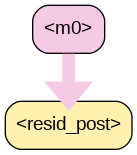

0 --------------------------------------------------
No edge 43
43
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43
New metric: 3.351525456786996e-07
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43
We moved to  blocks.0.hook_mlp_in[:]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43


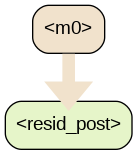

1 --------------------------------------------------
No edge 43
43
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 43
New metric: 3.351525456786996e-07

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.attn.hook_result [:, :, 3] is 7.762559854720323 (and current metric 3.351525456786996e-07)
Result is 7.762559519567778...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 6.439468799880398 (and current metric 3.351525456786996e-07)


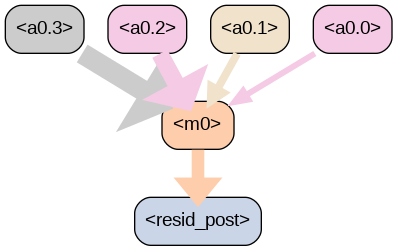

2 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_result[:, :, 2]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


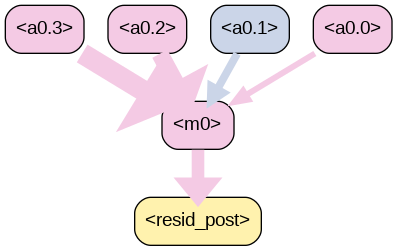

3 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_result[:, :, 1]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


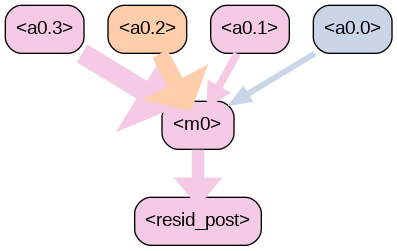

4 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_result[:, :, 0]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


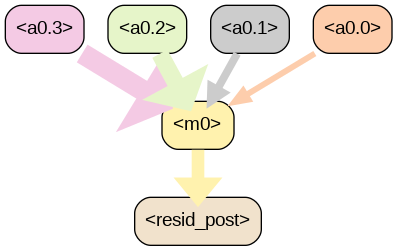

5 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_v[:, :, 3]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


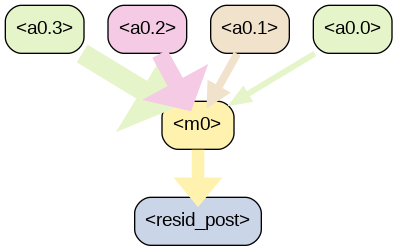

6 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_v_input [:, :, 3] is 8.80896242137372 (and current metric 0.11442894492861644)
Result is 8.694533476445102...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_v[:, :, 2]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


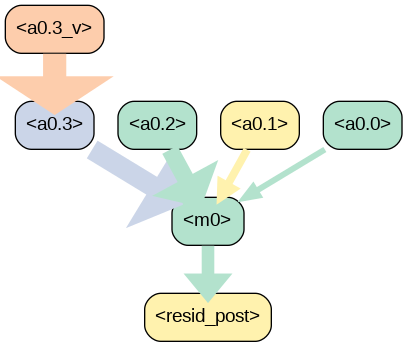

7 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_v_input [:, :, 2] is 6.8102863381397345 (and current metric 0.11442894492861644)
Result is 6.695857393211118...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_v[:, :, 1]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


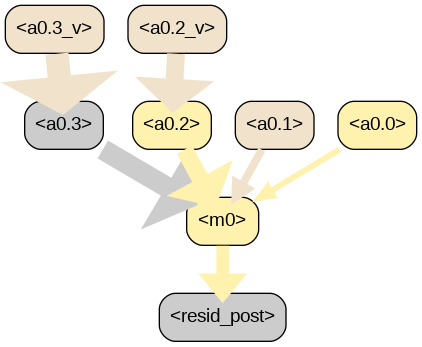

8 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_v_input [:, :, 1] is 5.82337972552226 (and current metric 0.11442894492861644)
Result is 5.708950780593644...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_v[:, :, 0]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


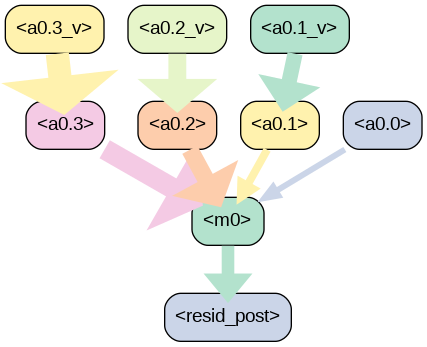

9 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_v, [:, :, 0]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_v_input [:, :, 0] is 2.2123742991293898 (and current metric 0.11442894492861644)
Result is 2.0979453542007733...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_k[:, :, 3]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


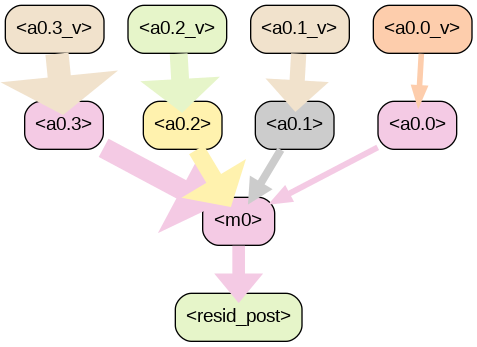

10 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_k_input [:, :, 3] is 1.0238200445488554 (and current metric 0.11442894492861644)
Result is 0.909391099620239...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_k[:, :, 2]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


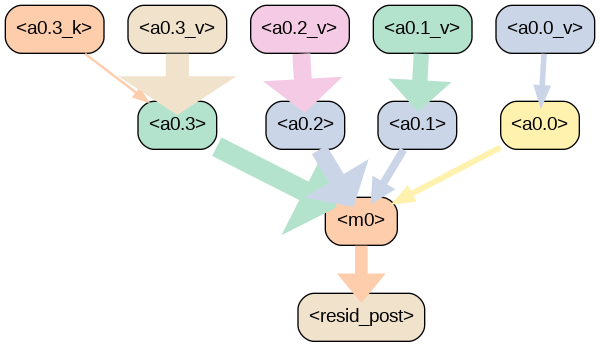

11 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_k_input [:, :, 2] is 1.0567464290844284 (and current metric 0.11442894492861644)
Result is 0.942317484155812...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_k[:, :, 1]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


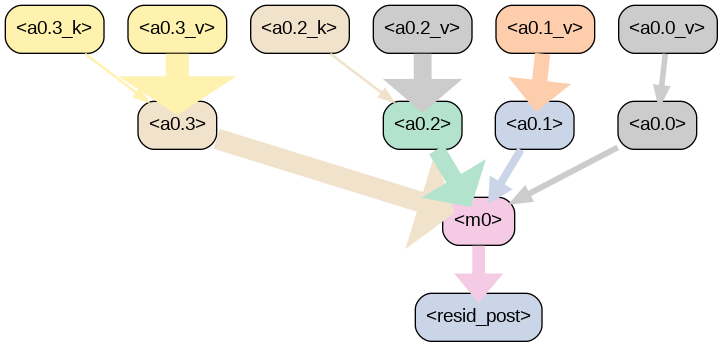

12 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_k_input [:, :, 1] is 2.5117552325995898 (and current metric 0.11442894492861644)
Result is 2.3973262876709733...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
We moved to  blocks.0.attn.hook_k[:, :, 0]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41


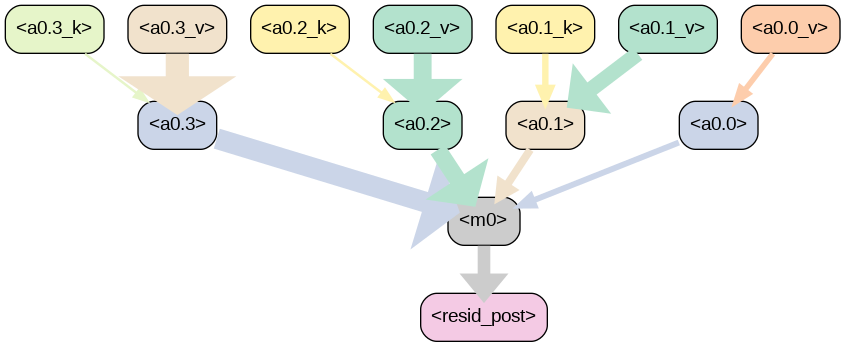

13 --------------------------------------------------
No edge 41
41
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 41
New metric: 0.11442894492861644

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_k, [:, :, 0]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_k_input [:, :, 0] is 0.6909659360055977 (and current metric 0.11442894492861644)
Result is 0.5765369910769813...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
We moved to  blocks.0.attn.hook_q[:, :, 3]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40


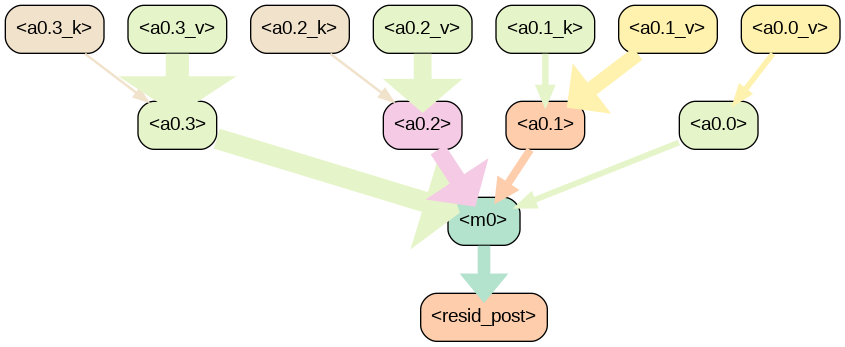

14 --------------------------------------------------
No edge 40
40
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
New metric: 0.6909659360055977

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_q_input [:, :, 3] is 2.4474114393368676 (and current metric 0.6909659360055977)
Result is 1.7564455033312698...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
We moved to  blocks.0.attn.hook_q[:, :, 2]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40


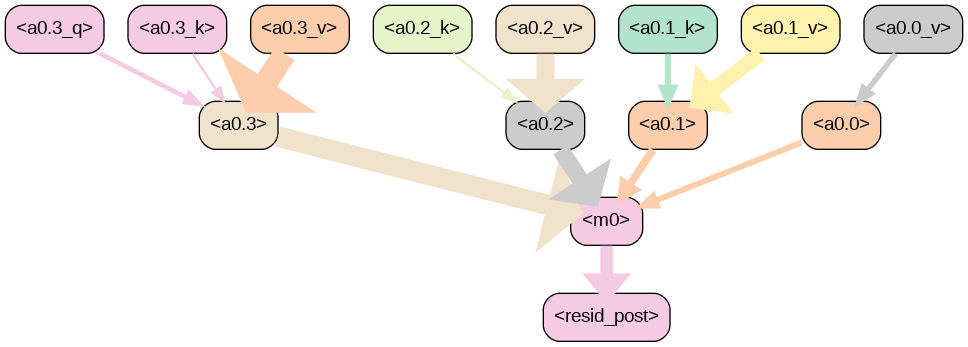

15 --------------------------------------------------
No edge 40
40
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
New metric: 0.6909659360055977

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_q_input [:, :, 2] is 1.7963105009432985 (and current metric 0.6909659360055977)
Result is 1.1053445649377007...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
We moved to  blocks.0.attn.hook_q[:, :, 1]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40


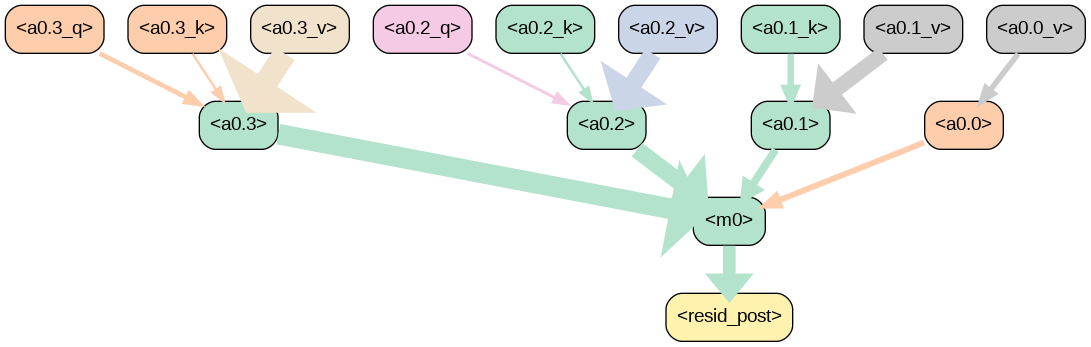

16 --------------------------------------------------
No edge 40
40
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
New metric: 0.6909659360055977

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_q_input [:, :, 1] is 1.999448503327668 (and current metric 0.6909659360055977)
Result is 1.3084825673220704...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
We moved to  blocks.0.attn.hook_q[:, :, 0]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40


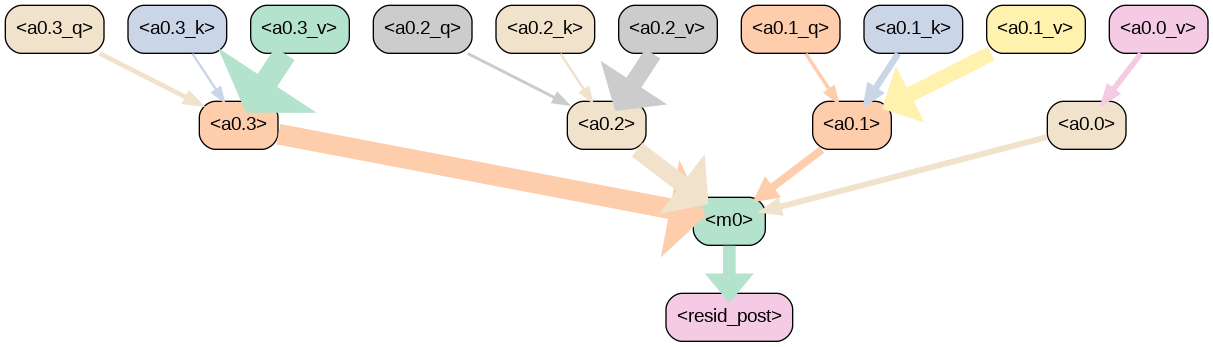

17 --------------------------------------------------
No edge 40
40
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 40
New metric: 0.6909659360055977

Node: cur_parent=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.attn.hook_q, [:, :, 0]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to blocks.0.hook_q_input [:, :, 0] is 0.6909659360055977 (and current metric 0.6909659360055977)
Result is 0.0...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 39
We moved to  blocks.0.hook_v_input[:, :, 3]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 39


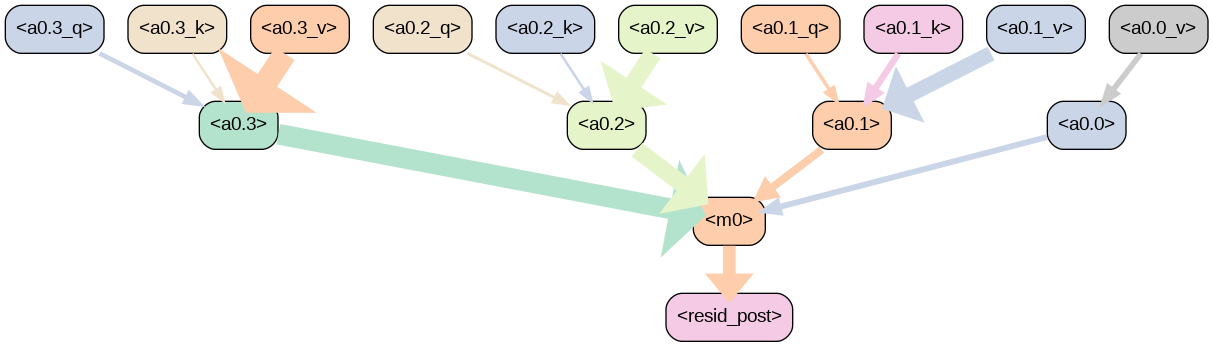

18 --------------------------------------------------
No edge 39
39
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 39
New metric: 0.6909659360055977

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 6.897740669380558 (and current metric 0.6909659360055977)
Result is 6.20677473337496...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 39

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 1.0722980534306867 (an

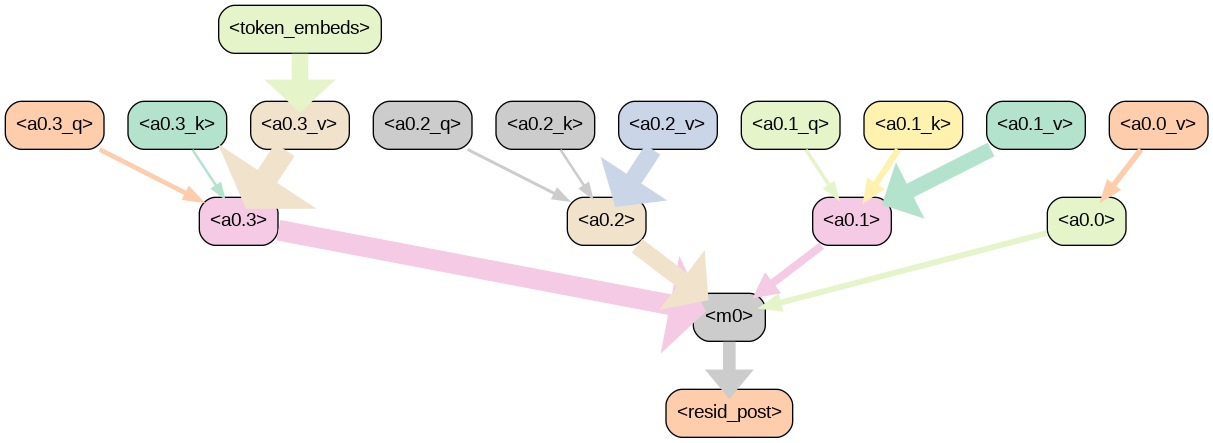

19 --------------------------------------------------
No edge 38
38
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 38
New metric: 1.0722980534306867

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 5.42698102179437 (and current metric 1.0722980534306867)
Result is 4.354682968363684...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 38

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 1.5191658330500608 (an

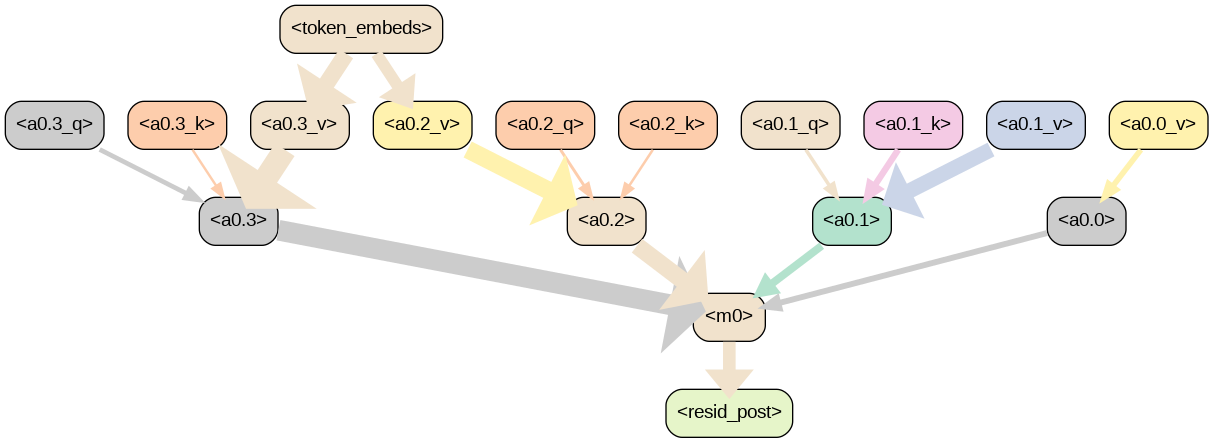

20 --------------------------------------------------
No edge 37
37
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 37
New metric: 1.5191658330500608

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 6.220011212029087 (and current metric 1.5191658330500608)
Result is 4.700845378979026...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 37

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 2.5105768062964167 (a

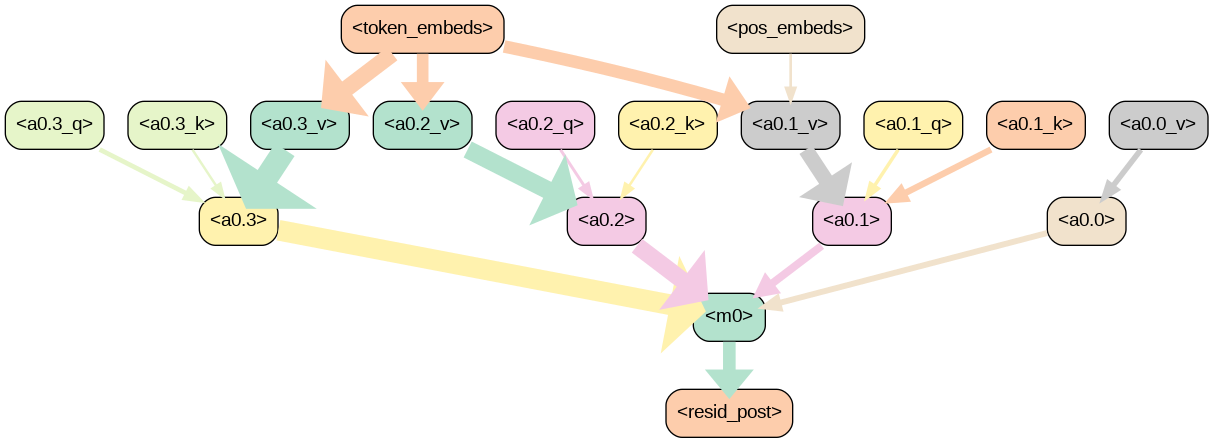

21 --------------------------------------------------
No edge 37
37
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 37
New metric: 1.5191658330500608

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 2.2539762939489454 (and current metric 1.5191658330500608)
Result is 0.7348104608988846...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 37

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_v_input, [:, :, 0]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 1.8019138605426037 

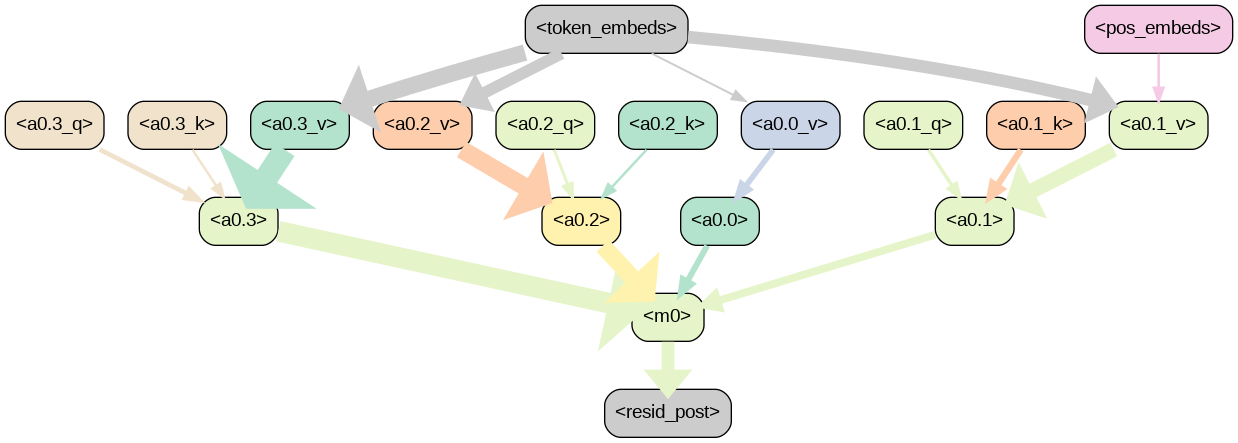

22 --------------------------------------------------
No edge 36
36
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 36
New metric: 1.8019138605426037

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 3.839415444999696 (and current metric 1.8019138605426037)
Result is 2.0375015844570923...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 36

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 1.7509968033701262 (

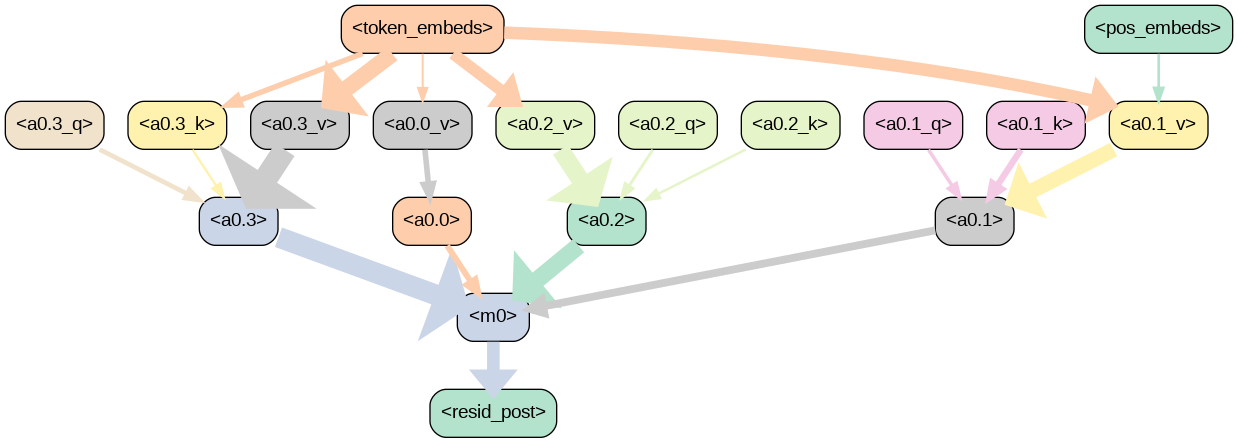

23 --------------------------------------------------
No edge 35
35
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 35
New metric: 1.7509968033701262

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 4.420914623014558 (and current metric 1.7509968033701262)
Result is 2.6699178196444318...so keeping connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 35

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 1.7352671379304532 (

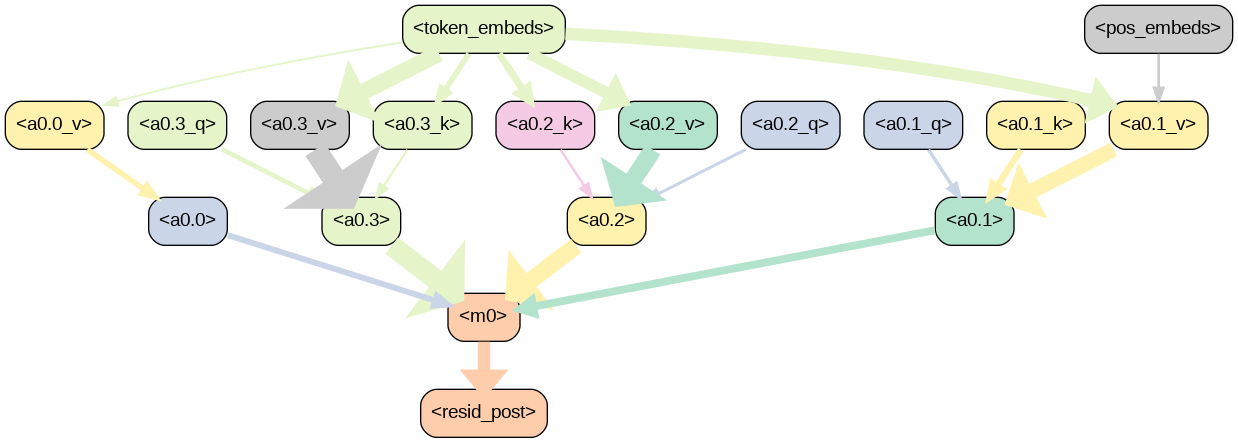

24 --------------------------------------------------
No edge 34
34
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 34
New metric: 1.7352671379304532

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 1.469688933618873 (and current metric 1.7352671379304532)
Result is -0.2655782043115802...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 33

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_k_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 2.7996927816560824

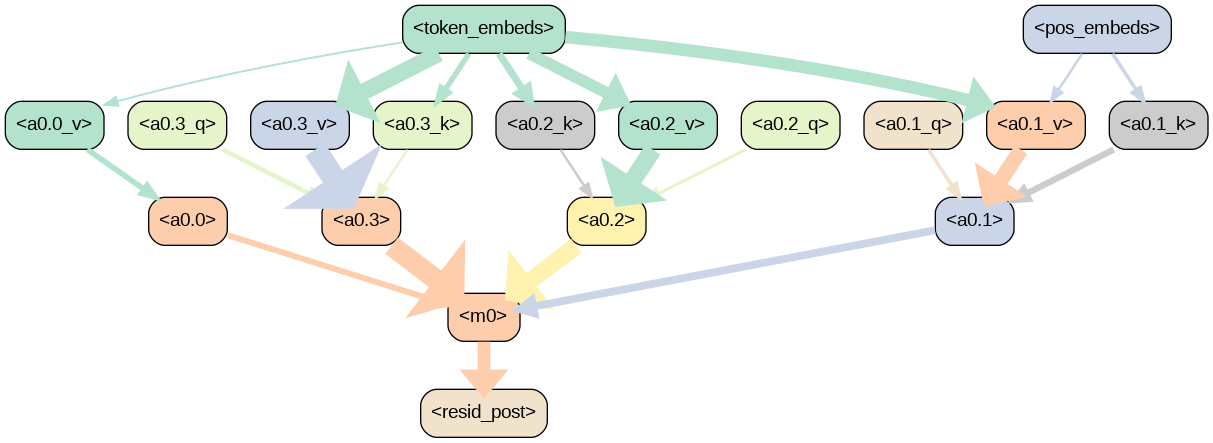

25 --------------------------------------------------
No edge 31
31
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 31
New metric: 1.469688933618873

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 1.4877522546233923 (and current metric 1.469688933618873)
Result is 0.01806332100451935...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 30

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 3]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 3.368260876475781 (

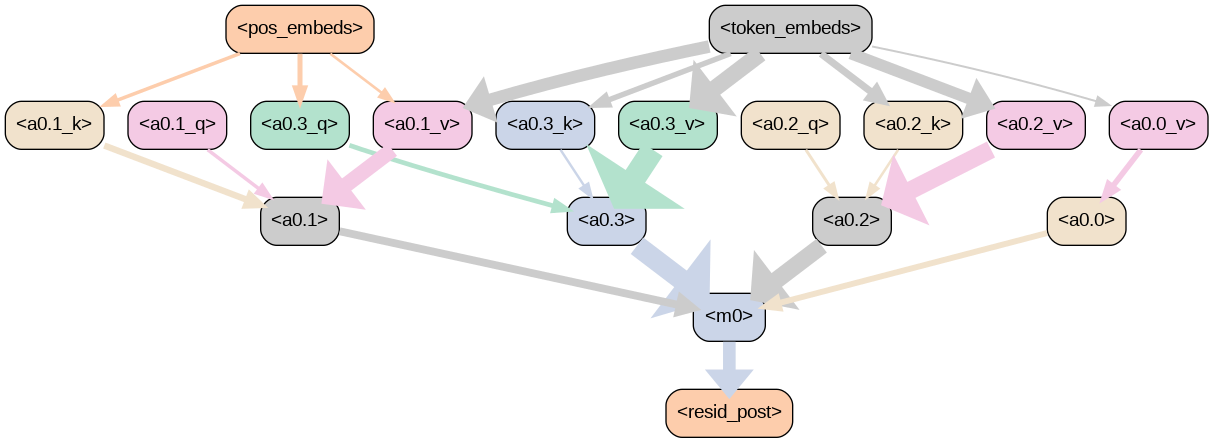

26 --------------------------------------------------
No edge 30
30
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 30
New metric: 1.4877522546233923

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 0.6518910778215391 (and current metric 1.4877522546233923)
Result is -0.8358611768018532...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 29

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 2]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 0.855970846509991

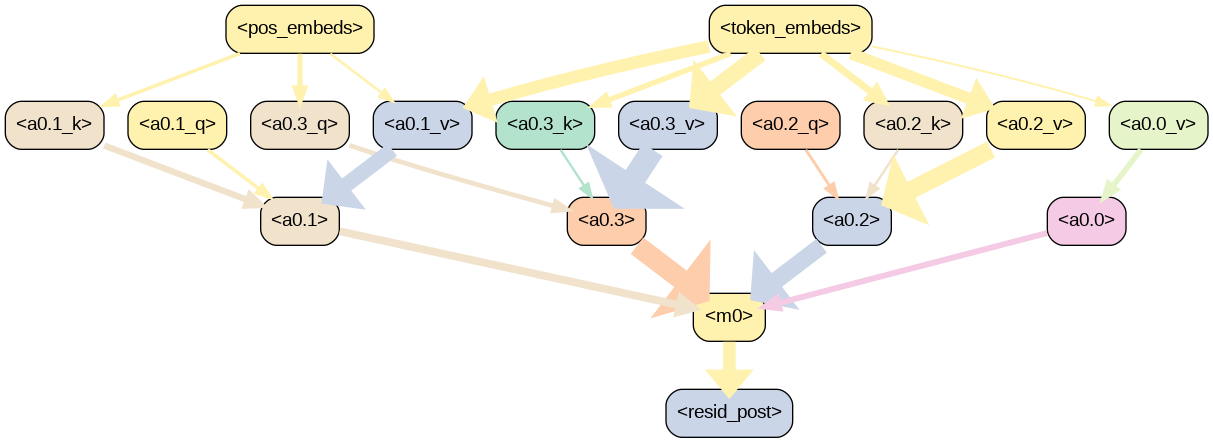

27 --------------------------------------------------
No edge 28
28
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 28
New metric: 0.8559708465099913

Node: cur_parent=TLACDCInterpNode(hook_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_embed [:] is 1.0289424044999655 (and current metric 0.8559708465099913)
Result is 0.1729715579899742...so removing connection
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 27

Node: cur_parent=TLACDCInterpNode(hook_pos_embed, [:]) (self.current_node=TLACDCInterpNode(blocks.0.hook_q_input, [:, :, 1]))

log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
Metric after removing connection to hook_pos_embed [:] is 2.241651553991462 

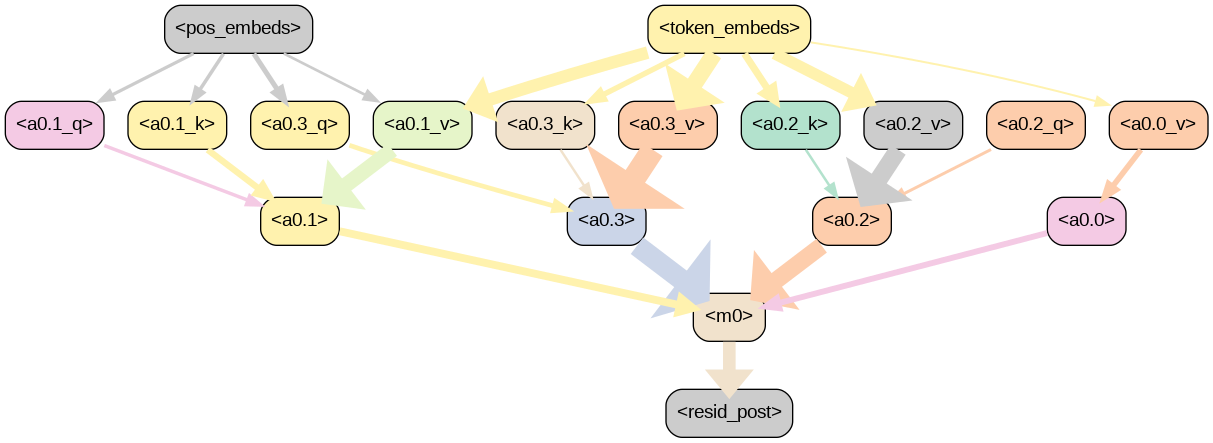

28 --------------------------------------------------
No edge 25
25
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 25
New metric: 1.0289424044999655
We moved to  hook_embed[:]
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 25


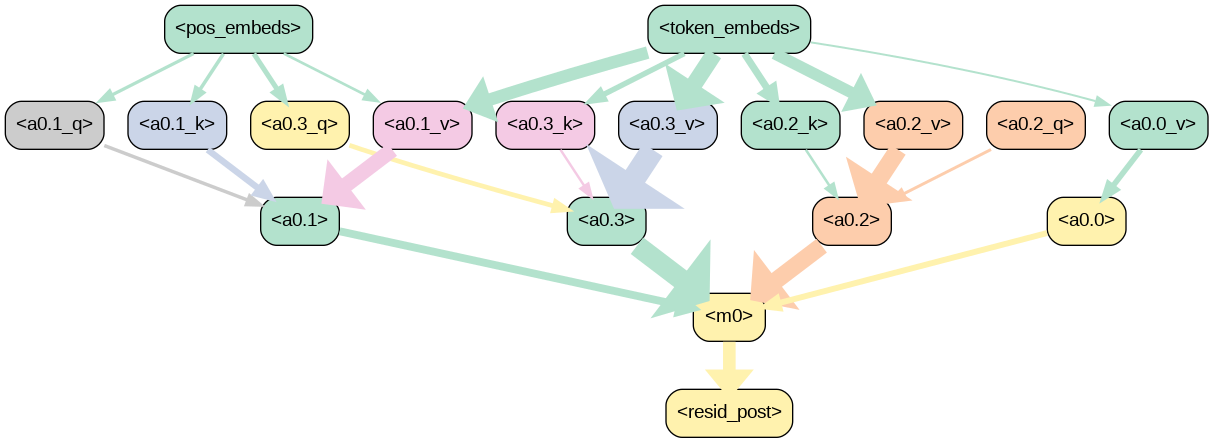

29 --------------------------------------------------
No edge 25
25
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 25
New metric: 1.0289424044999655
We moved to  None
log_probs:  torch.Size([100, 113])
labels:  torch.Size([12769])
labels:  torch.Size([12769, 1])
No edge 25


/usr/local/lib/python3.10/dist-packages/acdc/TLACDCExperiment.py:772: UserWarning: Finished iterating
  warnings.warn("Finished iterating")


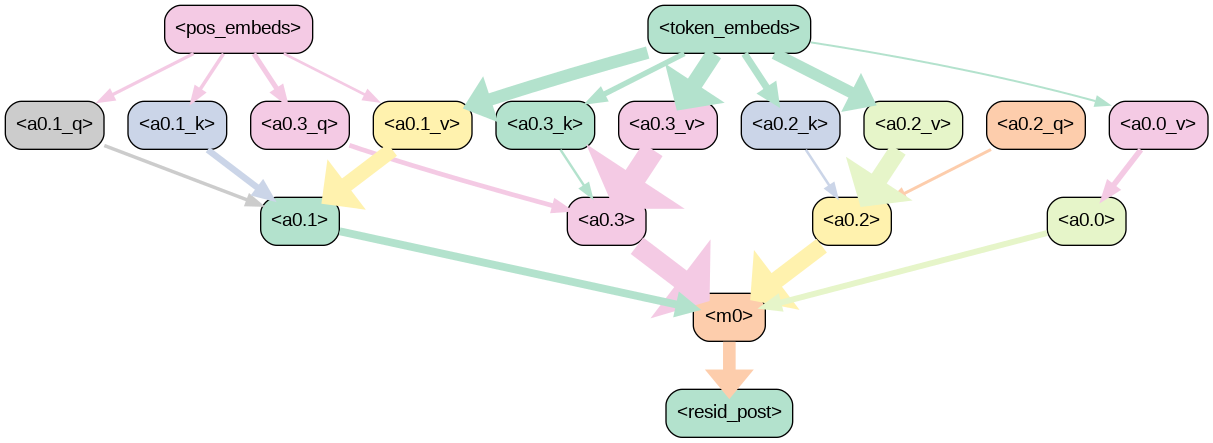

30 --------------------------------------------------
No edge 25
25


In [ ]:
for i in range(MAX_NUM_EPOCHS):
  experiment.step(testing=False)

  show(experiment.corr, f"./ims/img_new_{i+1}.png", show_full_index=False)

  # Comment out when not in Colab
  display(Image(f"./ims/img_new_{i+1}.png"))

  print(i, "-" * 50)
  print(experiment.count_no_edges())

  if i == 0:
    experiment.save_edges("edges.pkl")

  if experiment.current_node is None:
    break

experiment.save_edges("final_edges.pkl")

if USING_WANDB:
  edges_fname = f"edges.pth"
  experiment.save_edges(edges_fname)
  artifact = wandb.Artifact(edges_fname, type="dataset")
  artifact.add_file(edges_fname)
  wandb.log_artifact(artifact)
  os.remove(edges_fname)
  wandb.finish()

Hi guys. Lots of new things to update you on from my side.
1. ACDC is incompatible with Neels ad-hoc Transformer class which we have been using in the notebooks. We must use HookedTransformer because ACDC uses a lot of small functions and details which Neel elided from the Transformer class. Also, the weight tensors are organised differently for Transformer vs. HookedTransformer, so they are really not easily compatible. I have followed this video (https://www.youtube.com/watch?v=ob4vuiqG2Go&list=PL7m7hLIqA0hqsReJ0NYhyN3xiFQW9ko1h&index=1) which helped me implement the same architecture in HookedTransformer, and I think it is also a more easy to understand implementation in terms of inputs/outputs (Batu will appreciate this ;)). I have then trained the model on Colab in the notebook "hooked-transformer-training" which is in the shared folder. **Please use that notebook as the starting point for backdoor implementations on the small transformer**
2. There was a bug in the ACDC library which caused some incompatibility when running inference. Thus, I have forked ACDC, fixed that, and it works now. See https://github.com/nikolajjensen/Automatic-Circuit-Discovery for the implementation.
3. I have run ACDC on the small transformer which I trained using the updated ACDC library. The working example is in the "ACDC + Simple Transformer" notebook. I have NOT had time to consider a good metric, but at least i can get a pretty graph!

TODO:
1. GPT-2 backdoor (and backdoor dataset) which Jad is working on.
2. Small transformer backdoor (and backdoor dataset) which Batu is working on.
3. Good metrics for ACDC which I am working on.